## <font color='navy'> Examen 4. Laboratorio de Aprendizaje Estadístico.
    
### <font color='navy'> PCA, KMeans y Learners

Luis Fernando Márquez Bañuelos | 744489

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, plot_importance

pd.set_option('display.float_format', '{:,.4f}'.format)

## <font color='navy'> Importación de datos

In [2]:
data = pd.read_csv('hr_role.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


## <font color='navy'> Funciones

In [3]:
def histograma(probabilidades: np.ndarray, y_test: str):
    juntar = pd.DataFrame({
    'real': y_test,
    'probabilidades': probabilidades
    })
    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label = '1', color= 'skyblue')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label = '0', color = 'indianred')
    plt.title(f'Histograma de probabilidades de')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()

## <font color='navy'> Preparación de Datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

Ninguna de las variables del dataset tiene datos nulos, por lo que no será necesario hacer limpieza de datos. Sin embargo se pueden poner multiples variables en un tipo más adecuado.

In [5]:
categorical_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime'
]

int8_cols = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
             'JobInvolvement', 'JobLevel', 'RelationshipSatisfaction',
             'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance']

int32_cols = [
    'DailyRate', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
    'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating',
    'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

data[int8_cols] = data[int8_cols].astype('int8')
data[int32_cols] = data[int32_cols].apply(pd.to_numeric, downcast='integer')
data[categorical_cols] = data[categorical_cols].astype('category')

In [6]:
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
target = 'Attrition'
data = pd.get_dummies(data)

In [7]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

## <font color='navy'> 1- PCA

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

In [9]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)
X_componentes = pd.DataFrame(X_pca, columns=[f'PCA {i+1}' for i in range(X_pca.shape[1])])
X_componentes.head()

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,PCA 10,...,PCA 44,PCA 45,PCA 46,PCA 47,PCA 48,PCA 49,PCA 50,PCA 51,PCA 52,PCA 53
0,-0.0303,-2.3304,-1.1614,-3.2175,-0.1139,0.2535,-1.0405,0.3092,-0.4480,2.1116,...,0.0149,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000
1,0.0497,1.5437,-0.2139,1.6625,0.7196,-2.2080,1.0955,-1.0808,2.4273,1.2482,...,-0.1029,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
2,-2.9220,0.9963,-0.2068,-1.5847,-0.0958,0.0983,-2.7826,0.8389,0.4165,-0.6430,...,-0.0992,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000
3,-1.1874,1.0543,-0.6928,-2.3067,-0.2285,-2.3924,1.0586,-0.0715,-1.8439,1.8181,...,0.0460,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000
4,-2.1227,1.1964,0.5328,1.2881,-0.6940,1.6858,-0.5015,0.2727,-0.6313,-1.7150,...,0.1490,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000


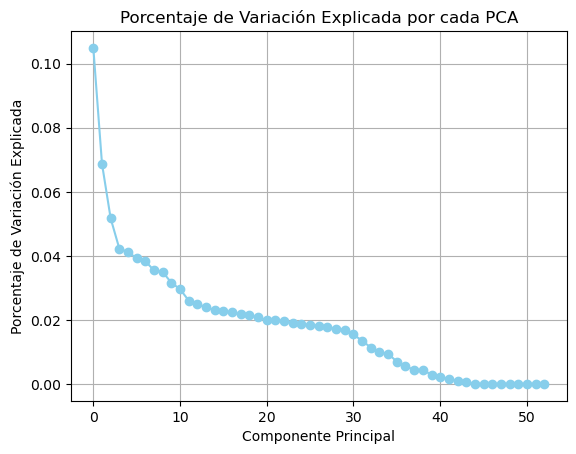

In [10]:
plt.plot(objeto_pca.explained_variance_ratio_, marker='o', color = 'skyblue')
plt.title('Porcentaje de Variación Explicada por cada PCA')
plt.xlabel('Componente Principal')
plt.ylabel('Porcentaje de Variación Explicada')
plt.grid()
plt.show()